In [1]:
# Imports

import dask.dataframe as dd
from datetime import datetime
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet, LassoCV
from sklearn.metrics import mean_squared_error, r2_score, make_scorer
from sklearn.model_selection import KFold, cross_val_score,train_test_split, RepeatedKFold, GridSearchCV
from sklearn.neighbors import KNeighborsRegressor
from sklearn.preprocessing import PolynomialFeatures, StandardScaler, OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.svm import SVR
import tensorflow as tf
from tensorflow.keras import backend as K
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization, Input, Embedding, Flatten, Concatenate
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam
from keras.callbacks import EarlyStopping, ModelCheckpoint
%matplotlib inline
pd.set_option('display.max_rows', 10000)

In [9]:
# Import external data

# Weather data
weather_data = pd.read_csv('data_external\Weather_Barcelona.csv',usecols=['time','apparent_temperature','precipitation'],dtype={'time':'object','apparent_temperature':'float64','precipitation':'float64'})
weather_data['time'] = pd.to_datetime(weather_data['time'])
weather_data['year'] = weather_data['time'].dt.year
weather_data['month'] = weather_data['time'].dt.month
weather_data['day'] = weather_data['time'].dt.day
weather_data['hour'] = weather_data['time'].dt.hour
weather_data = weather_data.drop_duplicates(subset=['year', 'month', 'day', 'hour'])

# Holiday data
holidays_data = pd.read_csv('data_external\Holidays_Barcelona.csv')
holidays_data['date'] = pd.to_datetime(holidays_data['date'])
holidays_data['is_holiday'] = 1
holidays_data = holidays_data.drop_duplicates(subset=['date'])

# Station data (I have adapted the original version to remove the strange 542/543 stations, and add 2 missing altitudes manually)
stations_data = pd.read_csv("data_external\Stations_Barcelona.csv",usecols=['station_id','post_code','altitude'],dtype={'station_id':'int64','post_code':'int64','altitude':'float64'})
stations_data['station_idx'] = stations_data.index

In [4]:
# Take pre-prepared data (in the same format as the validation set)

bicing_data = pd.read_csv('result\Bicing_context_percentage.csv',usecols=['station_id','year','month','day','hour','percentage_docks_available','ctx-1','ctx-2','ctx-3','ctx-4'],dtype={'station_id': 'int64','year':'int64','month':'int64','day':'int64','hour':'int64','percentage_docks_available': 'Float64','ctx-1': 'Float64','ctx-2': 'Float64','ctx-3': 'Float64','ctx-4': 'Float64'})
bicing_validation = pd.read_csv('validation\Validation_data.csv',usecols=['station_id','month','day','hour','ctx-1','ctx-2','ctx-3','ctx-4'],dtype={'station_id': 'int64','month':'int64','day':'int64','hour':'int64','ctx-1': 'Float64','ctx-2': 'Float64','ctx-3': 'Float64','ctx-4': 'Float64'})

# Remove stations 542 and 543 from bicing_data
bicing_data = bicing_data[~bicing_data['station_id'].isin([542, 543])]

# Remove the strange 2019 year
bicing_data = bicing_data[~bicing_data['year'].isin([2019])]

In [ ]:
# Preprocessing of the train, and test sets

# The original columns:
starting_features = ['station_id','year','month','day','hour','ctx-1','ctx-2','ctx-3','ctx-4']
categorical_features = ['weekday_name','weekday_type','month_name','post_code']
added_features = ['apparent_temperature','precipitation','is_holiday','hour_sin','hour_cos','month_sin','month_cos','weekday_sin','weekday_cos','day_sin','day_cos','altitude','station_idx']
original_columns = list(bicing_data.columns)
original_columns.remove('percentage_docks_available')

def process_data(data,datatype):

    # The validation and test sets do not have the year column, so we add it in order to lookup context information
    if(datatype=="test"):
        data['year'] = 2025
    
    # Create a date column from the year, month, day columns:
    data['date'] = pd.to_datetime(data[['year', 'month', 'day']])

    # Add weekday:
    data['weekday'] = data['date'].dt.weekday
    # Determine weekday name:
    data['weekday_name'] = data['date'].dt.day_name()
    # Determine whether the date is a weekend, return Weekday or Weekend:
    data['weekday_type'] = data['weekday_name'].apply(lambda x: 'Weekend' if x in ['Saturday', 'Sunday'] else 'Weekday')
    # Determine the month name:
    data['month_name'] = data['date'].dt.month_name()

    # Add weather data by year/month/day/hour
    data = pd.merge(
        data,
        weather_data[['year', 'month', 'day', 'hour', 'apparent_temperature','precipitation']],
        on=['year', 'month', 'day', 'hour'],
        how='left'
    )

    # Fix for Nans:
    data['apparent_temperature'] = data['apparent_temperature'].fillna(
        data.groupby('date')['apparent_temperature'].transform('mean')
    )

    # Add holidays data by date
    data = pd.merge(
        data,
        holidays_data[['date','is_holiday']],
        on = ['date'],
        how='left'
    )
    data['is_holiday'] = data['is_holiday'].fillna(0)

    # Add station information by station_id
    data = pd.merge(
        data,
        stations_data[['station_id','altitude','post_code','station_idx']],
        on = ['station_id'],
        how='left'
    )

    # Cyclical hour & date variables
    data['hour_sin'] = np.sin(2 * np.pi * data['hour'] / 24)
    data['hour_cos'] = np.cos(2 * np.pi * data['hour'] / 24)
    data['month_sin'] = np.sin(2 * np.pi * data['month'] / 12)
    data['month_cos'] = np.cos(2 * np.pi * data['month'] / 12)
    data['weekday_sin'] = np.sin(2 * np.pi * data['weekday'] / 7)
    data['weekday_cos'] = np.cos(2 * np.pi * data['weekday'] / 7)
    data['day_sin'] = np.sin(2 * np.pi * data['day'] / 365)
    data['day_cos'] = np.cos(2 * np.pi * data['day'] / 365)

    # Fit on training data and transform both
    if(datatype=="train"):
        # One-hot encoder
        ohe = OneHotEncoder(handle_unknown='ignore', sparse_output=False)

        # Preprocessor using ColumnTransformer
        global preprocessor
        # Combine starting and added features for numeric transformation
        nums = ['apparent_temperature','precipitation','altitude']
        cats = categorical_features
        pas = starting_features + ['is_holiday','hour_sin','hour_cos','month_sin','month_cos','weekday_sin','weekday_cos','day_sin','day_cos','station_idx']
        
        #print(data.columns - nums - cats - pas) DOUBLE CHECK THAT EVERYTHING IS BEING USED
        preprocessor = ColumnTransformer(transformers=[
            ('cat', ohe, cats),
            ('num', StandardScaler(), nums),
            ('passthrough', 'passthrough', pas)  # Pass through station_id as is
        ], verbose_feature_names_out=False)
        data = preprocessor.fit_transform(data)
    else:
        data = preprocessor.transform(data)
    
    data = data.astype(np.float64)
    return(data)

# Create the adapted train set
train_data, val_data, train_result, val_result = train_test_split(bicing_data[original_columns],bicing_data['percentage_docks_available'],test_size=0.01,shuffle=True)
test_data = bicing_validation.copy()


train_set = process_data(train_data, "train")
val_set = process_data(val_data, "validate")
test_set = process_data(test_data,"test")
column_names = preprocessor.get_feature_names_out()

train_set = pd.DataFrame(train_set, columns=column_names)
val_set = pd.DataFrame(val_set, columns=column_names)
test_set = pd.DataFrame(test_set, columns=column_names)

onehot_features = [col for col in train_set.columns if any(col.startswith(feature) for feature in categorical_features)]
print(f'Onehot features: {onehot_features}')

# Full list of features
features = starting_features + added_features + onehot_features
print(f'All features: {features}')

# Determine the exact datasets used for the models
train_set = train_set[features]
val_set = val_set[features]
test_set = test_set[features]

train_scaled = pd.DataFrame(train_set, columns=train_set.columns)
val_scaled = pd.DataFrame(val_set, columns=train_set.columns)
test_scaled = pd.DataFrame(test_set, columns=test_set.columns)

# Ensure that the train and test sets have the same columns
assert list(train_scaled.columns) == list(test_scaled.columns)
assert list(val_scaled.columns) == list(train_set.columns)

# Ensure that there are no NANs
assert not np.any(np.isnan(train_scaled)), "Input contains NaNs!"
assert not np.any(np.isnan(val_scaled)), "Input contains NaNs!"
assert not np.any(np.isnan(test_scaled)), "Input contains NaNs!"


Onehot features: ['weekday_name_Friday', 'weekday_name_Monday', 'weekday_name_Saturday', 'weekday_name_Sunday', 'weekday_name_Thursday', 'weekday_name_Tuesday', 'weekday_name_Wednesday', 'weekday_type_Weekday', 'weekday_type_Weekend', 'month_name_April', 'month_name_August', 'month_name_December', 'month_name_February', 'month_name_January', 'month_name_July', 'month_name_June', 'month_name_March', 'month_name_May', 'month_name_November', 'month_name_October', 'month_name_September', 'post_code_8001', 'post_code_8002', 'post_code_8003', 'post_code_8004', 'post_code_8005', 'post_code_8006', 'post_code_8007', 'post_code_8008', 'post_code_8009', 'post_code_8010', 'post_code_8011', 'post_code_8012', 'post_code_8013', 'post_code_8014', 'post_code_8015', 'post_code_8016', 'post_code_8017', 'post_code_8018', 'post_code_8019', 'post_code_8020', 'post_code_8021', 'post_code_8022', 'post_code_8023', 'post_code_8024', 'post_code_8025', 'post_code_8026', 'post_code_8027', 'post_code_8028', 'post_c

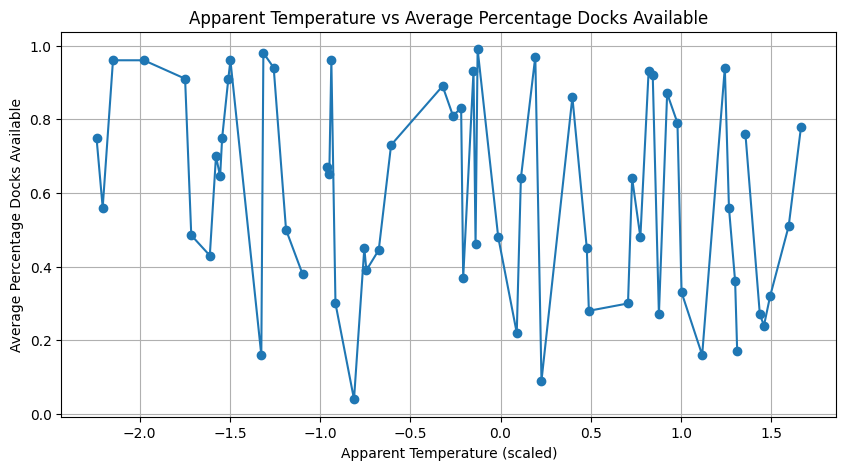

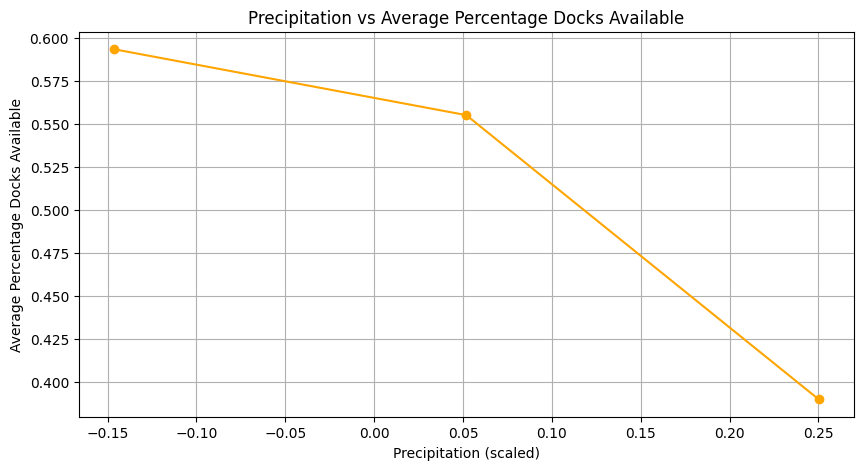

In [ ]:
# For testing purposes
train_with_target = train_scaled.copy()
train_with_target['percentage_docks_available'] = train_result
train_with_target.head()
train_with_target = train_with_target[train_with_target['station_id']==100]
train_with_target = train_with_target[train_with_target['year']==2022]
train_with_target = train_with_target[train_with_target['hour']==9]

# Apparent temperature vs average percentage docks available
plt.figure(figsize=(10, 5))
avg_temp = train_with_target.groupby('apparent_temperature')['percentage_docks_available'].mean()
plt.plot(avg_temp.index, avg_temp.values, marker='o')
plt.xlabel('Apparent Temperature (scaled)')
plt.ylabel('Average Percentage Docks Available')
plt.title('Apparent Temperature vs Average Percentage Docks Available')
plt.grid(True)
plt.show()

# Precipitation vs average percentage docks available
plt.figure(figsize=(10, 5))
avg_precip = train_with_target.groupby('precipitation')['percentage_docks_available'].mean()
plt.plot(avg_precip.index, avg_precip.values, marker='o', color='orange')
plt.xlabel('Precipitation (scaled)')
plt.ylabel('Average Percentage Docks Available')
plt.title('Precipitation vs Average Percentage Docks Available')
plt.grid(True)
plt.show()

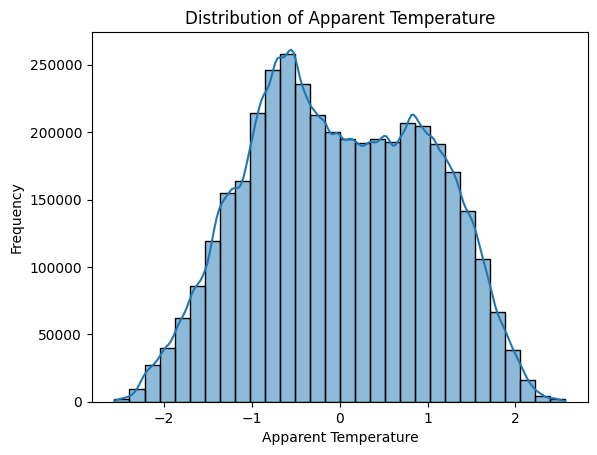

In [224]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.histplot(train_scaled['apparent_temperature'], bins=30, kde=True)
plt.title('Distribution of Apparent Temperature')
plt.xlabel('Apparent Temperature')
plt.ylabel('Frequency')
plt.show()

In [23]:
# Data
testing_num = len(train_result)
used_features = ['ctx-1','ctx-2','ctx-3','ctx-4','is_holiday','apparent_temperature','hour_sin', 'hour_cos', 'month_sin', 'month_cos', 'weekday_sin', 'weekday_cos', 'day_sin', 'day_cos','altitude']
from_all = ['station_id','station_idx', 'year', 'month', 'day', 'hour', 'ctx-1', 'ctx-2', 'ctx-3', 'ctx-4', 'apparent_temperature', 'precipitation', 'is_holiday', 'hour_sin', 'hour_cos', 'month_sin', 'month_cos', 'weekday_sin', 'weekday_cos', 'day_sin', 'day_cos', 'altitude', 'weekday_name_Friday', 'weekday_name_Monday', 'weekday_name_Saturday', 'weekday_name_Sunday', 'weekday_name_Thursday', 'weekday_name_Tuesday', 'weekday_name_Wednesday', 'weekday_type_Weekday', 'weekday_type_Weekend', 'month_name_April', 'month_name_August', 'month_name_December', 'month_name_February', 'month_name_January', 'month_name_July', 'month_name_June', 'month_name_March', 'month_name_May', 'month_name_November', 'month_name_October', 'month_name_September', 'post_code_8001', 'post_code_8002', 'post_code_8003', 'post_code_8004', 'post_code_8005', 'post_code_8006', 'post_code_8007', 'post_code_8008', 'post_code_8009', 'post_code_8010', 'post_code_8011', 'post_code_8012', 'post_code_8013', 'post_code_8014', 'post_code_8015', 'post_code_8016', 'post_code_8017', 'post_code_8018', 'post_code_8019', 'post_code_8020', 'post_code_8021', 'post_code_8022', 'post_code_8023', 'post_code_8024', 'post_code_8025', 'post_code_8026', 'post_code_8027', 'post_code_8028', 'post_code_8029', 'post_code_8030', 'post_code_8031', 'post_code_8032', 'post_code_8033', 'post_code_8034', 'post_code_8035', 'post_code_8036', 'post_code_8037', 'post_code_8038', 'post_code_8039', 'post_code_8040', 'post_code_8041', 'post_code_8042', 'post_code_8930']

# Training data
X_train = (train_scaled[used_features]).values
X_train_idx = train_scaled['station_idx'].values
y_train = train_result.astype(float).values

# Validation data
X_val = val_scaled[used_features].values
X_val_idx = val_scaled['station_idx'].values
y_val = val_result.values

# Testing (final) data
X_test = test_scaled[used_features].values


In [30]:
try:
    del model
except NameError:
    pass

K.clear_session()

In [31]:
station_input = Input(shape=(1,), name="station_idx")
numeric_input = Input(shape=(X_train.shape[1],), name="numeric_feats")

N_stations = len(stations_data)
embedding_dim = 8

# Look up an 8-dim vector for each station index
emb = Embedding(input_dim=N_stations, output_dim=embedding_dim, name="station_embedding")(station_input)
station_vec = Flatten(name="station_flatten")(emb)

merged = Concatenate(name="merge")(
    [station_vec, numeric_input]
)

m1 = Dense(256, activation='relu')(merged)
m2 = BatchNormalization()(m1)

m3 = Dense(128, activation='relu')(m2)
m4 = BatchNormalization()(m3)

m5 = Dense(64, activation='relu')(m4)
m6 = BatchNormalization()(m5)

m7 = Dense(32, activation='relu')(m6)
m8 = BatchNormalization()(m7)

# Final sigmoid
out = Dense(1, activation='sigmoid')(m8)

model = Model(
    inputs = [station_input, numeric_input],
    outputs = out
)

# Define the RMSE as the loss function
def rmse_loss(y_true, y_pred):
    return tf.sqrt(tf.reduce_mean(tf.square(y_true - y_pred)))

model.compile(optimizer=Adam(learning_rate=0.0001), loss=rmse_loss)

model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ station_idx         │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ station_embedding   │ (None, 1, 8)      │      4,112 │ station_idx[0][0] │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ station_flatten     │ (None, 8)         │          0 │ station_embeddin… │
│ (Flatten)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ numeric_feats       │ (None, 15)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ merge (Concatenate) │ (None, 23)        │          0 │ station_flatten[… │
│                     │                   │            │ numeric_feats[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 256)       │      6,144 │ merge[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 256)       │      1,024 │ dense[0][0]       │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 128)       │     32,896 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 128)       │        512 │ dense_1[0][0]     │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 64)        │      8,256 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 64)        │        256 │ dense_2[0][0]     │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_3 (Dense)     │ (None, 32)        │      2,080 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 32)        │        128 │ dense_3[0][0]     │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_4 (Dense)     │ (None, 1)         │         33 │ batch_normalizat… │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 55,441 (216.57 KB)

 Trainable params: 54,481 (212.82 KB)

 Non-trainable params: 960 (3.75 KB)

In [ ]:
early_stopping = EarlyStopping(
    monitor='loss',
    patience=5,
    restore_best_weights=True,
    min_delta=0.00005,
)

model_checkpoint = ModelCheckpoint(
    'best_model.keras',
    monitor='loss',
    save_best_only=True
)

reduce_lr = ReduceLROnPlateau(
    monitor='loss',      # or 'val_loss' if you have validation data
    factor=0.5,          # Reduce learning rate by this factor
    patience=3,          # Number of epochs with no improvement before reducing LR
    verbose=1,
    min_lr=5e-6          # Minimum learning rate
)

history = model.fit(
    {
        "station_idx": X_train_idx,
        "numeric_feats": X_train
    },
    y_train,
    validation_data = (
      {"station_idx":  X_val_idx, "numeric_feats": X_val},
      y_val
    ),
    epochs=100,
    batch_size=500,
    verbose=1,
    callbacks=[early_stopping, model_checkpoint, reduce_lr]  # <- include it here
)

Epoch 1/100
8241/8241 ━━━━━━━━━━━━━━━━━━━━ 45s 5ms/step - loss: 0.1229 - val_loss: 0.1027 - learning_rate: 1.0000e-04
Epoch 2/100
8241/8241 ━━━━━━━━━━━━━━━━━━━━ 42s 5ms/step - loss: 0.1033 - val_loss: 0.1003 - learning_rate: 1.0000e-04
Epoch 3/100
8241/8241 ━━━━━━━━━━━━━━━━━━━━ 44s 5ms/step - loss: 0.1016 - val_loss: 0.0992 - learning_rate: 1.0000e-04
Epoch 4/100
8241/8241 ━━━━━━━━━━━━━━━━━━━━ 42s 5ms/step - loss: 0.1007 - val_loss: 0.0986 - learning_rate: 1.0000e-04
Epoch 5/100
8241/8241 ━━━━━━━━━━━━━━━━━━━━ 42s 5ms/step - loss: 0.1001 - val_loss: 0.0983 - learning_rate: 1.0000e-04
Epoch 6/100
8241/8241 ━━━━━━━━━━━━━━━━━━━━ 50s 6ms/step - loss: 0.0997 - val_loss: 0.0978 - learning_rate: 1.0000e-04
Epoch 7/100
8241/8241 ━━━━━━━━━━━━━━━━━━━━ 54s 6ms/step - loss: 0.0994 - val_loss: 0.0976 - learning_rate: 1.0000e-04
Epoch 8/100
8241/8241 ━━━━━━━━━━━━━━━━━━━━ 54s 7ms/step - loss: 0.0991 - val_loss: 0.0974 - learning_rate: 1.0000e-04
Epoch 9/100
8241/8241 ━━━━━━━━━━━━━━━━━━━━ 57s 7ms/step 

123563/123563 ━━━━━━━━━━━━━━━━━━━━ 156s 1ms/step


c:\Users\sophi\anaconda3\envs\mlflow_env\lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


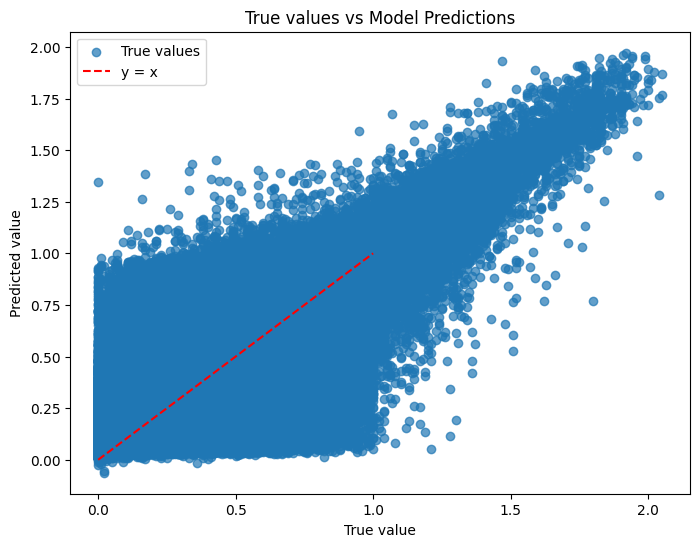

In [271]:
import matplotlib.pyplot as plt

# Get model predictions on your training data (or validation data)
y_pred = model.predict(X_train)

# If y_train or y_pred are scaled between 0 and 1, you can plot directly
plt.figure(figsize=(8,6))
plt.scatter(y_train,y_pred, label='True values', alpha=0.7)
plt.plot([0, 1], [0, 1], color='red', linestyle='--', label='y = x')
plt.xlabel('True value')
plt.ylabel('Predicted value')
plt.title('True values vs Model Predictions')
plt.legend()
plt.show()



In [16]:
y_train[y_train > 1.5]
len(y_train[y_train > 1.5])

1116

In [17]:
train_loss = model.evaluate(X_train, y_train, verbose=0)
print(f"Final loss on training set: {train_loss:.4f}")

val_loss = model.evaluate(X_val, y_val, verbose=0)
print(f"Final loss on validation set: {val_loss:.4f}")

Final loss on training set: 0.1005
Final loss on validation set: 0.1010


In [18]:
predictions = model.predict(X_test)

predictions

8911/8911 ━━━━━━━━━━━━━━━━━━━━ 9s 1ms/step


array([[0.666782  ],
       [0.46119618],
       [0.53177094],
       ...,
       [0.7443009 ],
       [0.81383634],
       [0.6740911 ]], dtype=float32)

In [19]:
# Save predictions to CSV
submission_df = pd.DataFrame({
    'percentage_docks_available': predictions.flatten()
})
submission_df.index.name = 'index'
submission_df.to_csv('submissions/submissions_v5_cyclical_dates.csv')